In [1]:
import pandas as pd
s = pd.read_csv("data/ENERGY_SETTLEMENT_PRICE.csv", parse_dates=["TIME"], index_col="TIME")
s = s['VALUE'].asfreq("H").interpolate(method="linear")
s.index.name = None

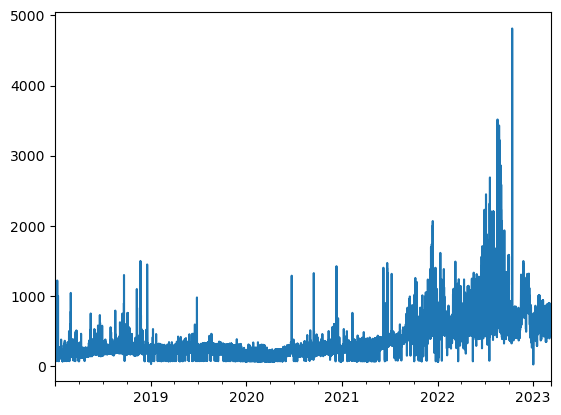

In [2]:
s.plot();

Average method:

the forecasts of all future values are equal to the average (or “mean”) of the historical data

In [3]:
s.mean()

362.7230529903254

Naïve method

This method works remarkably well for many economic and financial time series.
Because a naïve forecast is optimal when data follow a random walk, these are also called random walk forecasts.

In [4]:
s.iloc[-1]

596.11

Seasonal naïve method

A similar method is useful for highly seasonal data. In this case, we set each forecast to be equal to the last observed value from the same season. For example, with monthly data, the forecast for all future February values is equal to the last observed February value. This model is useful when we have a clear and large seasonal variation in our time series

In [5]:
s.iloc[-24]

567.61

Drift Model

An extension of the naive forecast where we let the prediction either linearly increase or decrease through time as a function of time step, h, scaled by the average historical trend. It fails to capture any seasonality in the forecast which is observed in the data

A variation on the naïve method is to allow the forecasts to increase or decrease over time, where the amount of change over time (called the drift) is set to be the average change seen in the historical data

In [6]:
diff = s.iloc[-1] - s.iloc[0]
trend = diff / (len(s) - 1)
h = 1
s.iloc[-1] + h * trend

596.1215231205612

Residuals:

The “residuals” in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values. Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts. (ACF)
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

Adjusting for bias is easy: if the residuals have mean m, then simply add m
to all forecasts and the bias problem is solved

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

3. The residuals have constant variance (homoscedastic)
4. The residuals are normally distributed.

These two properties make the calculation of prediction intervals easier. However, a forecasting method that does not satisfy these properties cannot necessarily be improved. Sometimes applying a Box-Cox transformation may assist with these properties, but otherwise there is usually little that you can do to ensure that your residuals have constant variance and a normal distribution. Instead, an alternative approach to obtaining prediction intervals is necessary

Portmanteau tests for autocorrelation

In addition to looking at the ACF plot, we can also do a more formal test for autocorrelation by considering a whole set of rk values as a group, rather than treating each one separately.

When we look at the ACF plot to see whether each spike is within the required limits, we are implicitly carrying out multiple hypothesis tests, each one with a small probability of giving a false positive. When enough of these tests are done, it is likely that at least one will give a false positive, and so we may conclude that the residuals have some remaining autocorrelation, when in fact they do not.

n order to overcome this problem, we test whether the first h
autocorrelations are significantly different from what would be expected from a white noise process. A test for a group of autocorrelations is called a portmanteau test, from a French word describing a suitcase or coat rack carrying several items of clothing.

In [7]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(s.iloc[:200]).fit()
res = model.resid

sm.stats.acorr_ljungbox(res, lags=[5], boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
5,184.015677,7.424468e-38,179.876103,5.687251e-37


The Breusch-Godfrey test is similar to the Ljung-Box test, but it is specifically designed for use with regression models.

In [8]:
max_lags = 5
df = pd.concat([res.shift(x) for x in range(max_lags + 1)], axis=1)
df.columns = list(map(lambda x: f"lag {x}", range(max_lags + 1)))

df.corr()

,lag 0,lag 1,lag 2,lag 3,lag 4,lag 5
lag 0,1.000000,0.532756,0.445515,0.418551,0.395645,0.309952
lag 1,0.532756,1.000000,0.532862,0.445536,0.419088,0.395832
lag 2,0.445515,0.532862,1.000000,0.532778,0.445547,0.419031
lag 3,0.418551,0.445536,0.532778,1.000000,0.532793,0.445496
lag 4,0.395645,0.419088,0.445547,0.532793,1.000000,0.532794
lag 5,0.309952,0.395832,0.419031,0.445496,0.532794,1.000000


In [9]:
rk = df.corr().iloc[0, 1:]
T = len(df)

ss = sum(((T - k + 1) ** -1) * r**2 for k, r in enumerate(rk))
lung = T * (T+2) * ss
lung


184.34822516817175

In [10]:
ss = sum(r**2 for r in rk)
box_pierce = T * ss
box_pierce

182.0205152454434

large values of Q suggest that the autocorrelations do not come from a white noise series.
If the autocorrelations did come from a white noise series, then both  
would have a distribution with l degrees of freedom

In [11]:
import numpy as np

m = res.mean()
lag = 3

np.cov(res.iloc[lag:], res.shift(lag).iloc[lag:])[1, 0] / np.var(res)

sum((res.iloc[lag:] - m) * (res.shift(lag).iloc[lag:] - m)) / sum((res - m) ** 2)


0.41574026472755365

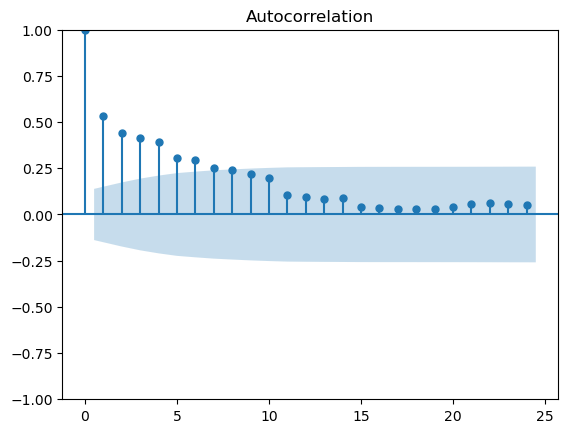

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(res);

Forecast errors

A forecast “error” is the difference between an observed value and its forecast. Here “error” does not mean a mistake, it means the unpredictable part of an observation

Note that forecast errors are different from residuals in two ways. First, residuals are calculated on the training set while forecast errors are calculated on the test set. Second, residuals are based on one-step forecasts while forecast errors can involve multi-step forecasts.

Scale-dependent errors

MAE, RMSE

When comparing forecast methods applied to a single time series, or to several time series with the same units, the MAE is popular as it is easy to both understand and compute. A forecast method that minimises the MAE will lead to forecasts of the median, while minimising the RMSE will lead to forecasts of the mean. Consequently, the RMSE is also widely used, despite being more difficult to interpret.

Percentage errors

Percentage errors have the advantage of being unit-free, and so are frequently used to compare forecast performances between data sets. The most commonly used measure is: MAPE

Measures based on percentage errors have the disadvantage of being infinite or undefined if  
for any yt in the period of interest, and having extreme values if any  
yt is close to zero. Another problem with percentage errors that is often overlooked is that they assume the unit of measurement has a meaningful zero.3 For example, a percentage error makes no sense when measuring the accuracy of temperature forecasts on either the Fahrenheit or Celsius scales, because temperature has an arbitrary zero point.

They also have the disadvantage that they put a heavier penalty on negative errors than on positive errors. This observation led to the use of the so-called “symmetric” MAPE (sMAPE)

Hyndman & Koehler (2006) recommend that the sMAPE not be used.


Scaled errors: MASE

In [13]:
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError
from sktime.forecasting.var import VAR
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

metrics = MeanSquaredError(square_root=True)

def calculate_error(y_true: pd.Series, y_pred: pd.Series, metric) -> float:
    return metric(y_true, y_pred)




c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


143.98653550686092

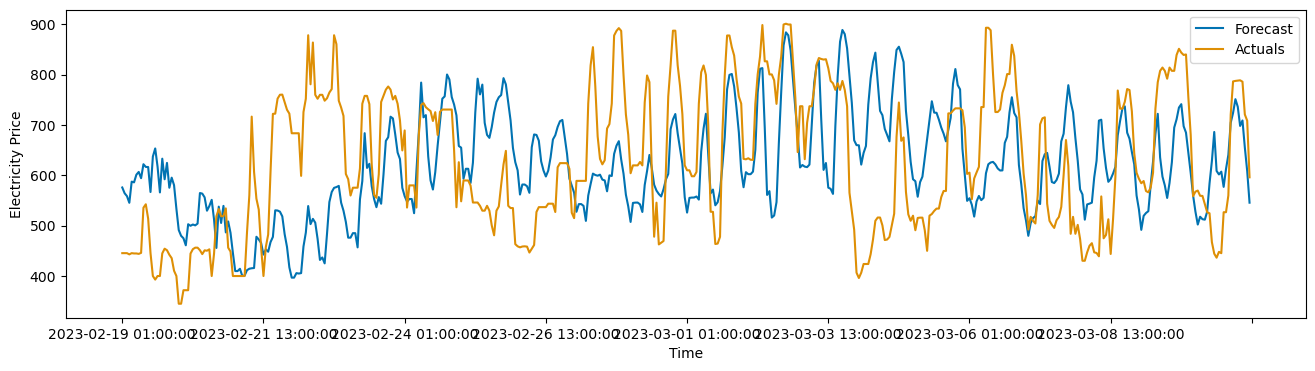

In [14]:
period = 24
initial = 45000
y_test = s.iloc[initial:]

fh = ForecastingHorizon(values=list(range(1, period + 1)))

forecaster = NaiveForecaster(strategy="mean", sp=period, window_length=period*3)
sp = ExpandingWindowSplitter(fh=fh, step_length=period, initial_window=initial)
gen = sp.split(s)

y_pred = pd.Series(dtype='float64')

for train_idx, test_idx in gen:
    train = s.iloc[train_idx]
    test = s.iloc[test_idx]
    
    forecaster.fit(train)
    preds = forecaster.predict(fh=fh)
    
    res = test - preds
    
    # print(res.mean())
    # res.plot()
    # acc = sm.stats.acorr_ljungbox(res, lags=5).values[0][1]
    # print(acc)    
    # assert acc > 0.05
    
    y_pred = pd.concat((y_pred, preds))

y_pred = y_pred.asfreq("H")

plot_series(y_pred, y_test, labels=["Forecast", "Actuals"], markers=[None, None], y_label='Electricity Price', x_label='Time');

calculate_error(y_test, y_pred, metrics)

In [26]:
size = 10

index = pd.date_range("2023-01-01", periods=12*size, freq="M")
vals = [1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2]

v = []

for i in range(size):
    v += list(map(lambda x: x + i, vals))

ts = pd.Series(data=v, index=index)
ts.tail()

2032-08-31    15
2032-09-30    14
2032-10-31    13
2032-11-30    12
2032-12-31    11
Freq: M, dtype: int64

In [156]:
from sktime.forecasting.base import ForecastingHorizon


def make_forecast(model, actuals: pd.Series):
    fh = ForecastingHorizon(actuals.index, is_relative=False)
    model.fit(actuals)
    in_sample = model.predict(fh)
    preds = m.predict(fh=np.arange(1, 13))
    plot_series(actuals.to_period(), preds.to_period(), in_sample.to_period(), labels=["ACTUAL", "FORECAST", "FITTED"])

c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\sktime\forecasting\base\_base.py:1035: UserWarning: empty y passed to update_predict, no update was carried out
  warn("empty y passed to update_predict, no update was carried out")


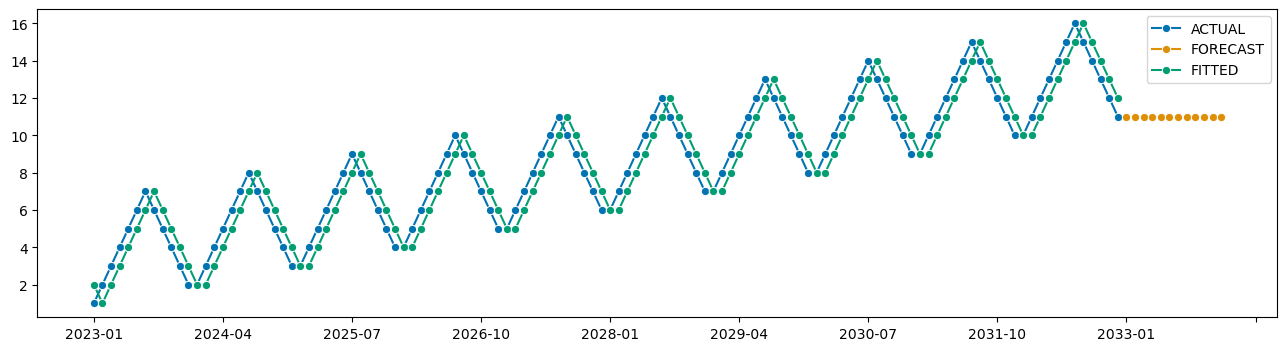

In [157]:
import numpy as np

m = NaiveForecaster(strategy="last")
make_forecast(m, ts)

c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\sktime\forecasting\base\_base.py:1035: UserWarning: empty y passed to update_predict, no update was carried out
  warn("empty y passed to update_predict, no update was carried out")


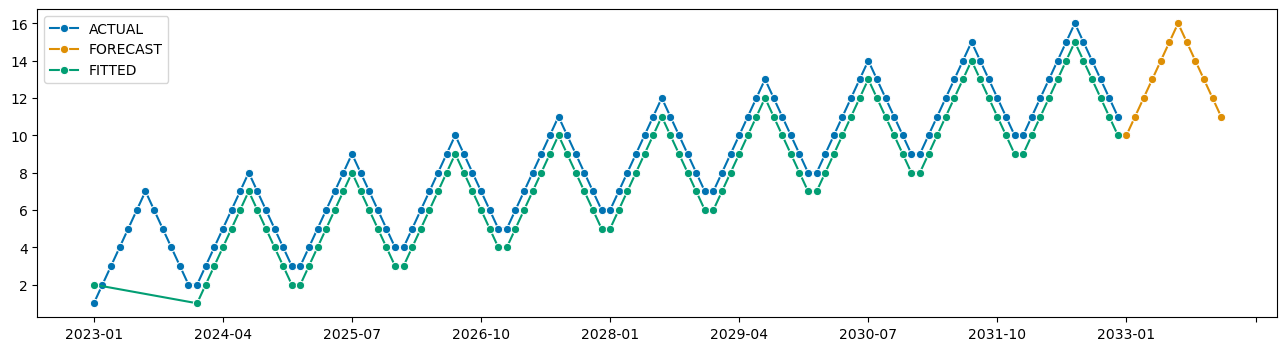

In [158]:
m = NaiveForecaster(strategy="last", sp=12)
make_forecast(m, ts)

c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\sktime\forecasting\base\_base.py:1035: UserWarning: empty y passed to update_predict, no update was carried out
  warn("empty y passed to update_predict, no update was carried out")
c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\sktime\forecasting\naive.py:242: RuntimeWarning: Mean of empty slice
  y_pred = np.nanmean(last_window, axis=0)
c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\sktime\forecasting\naive.py:242: RuntimeWarning: Mean of empty slice
  y_pred = np.nanmean(last_window, axis=0)
c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\sktime\forecasting\naive.py:242: RuntimeWarning: Mean of empty slice
  y_pred = np.nanmean(last_window, axis=0)
c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\sktime\forecasting\naive.py:242: RuntimeWarning: Mean of empty slice
  y_pred = np.nanmean(last_window, axis=0)
c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\sktime\forecasting\naive.py:242: R

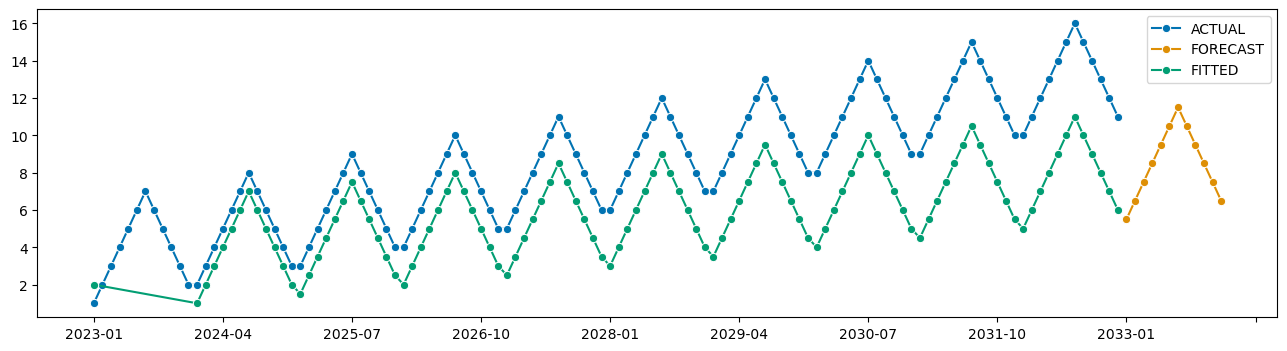

In [159]:
m = NaiveForecaster(strategy="mean", sp=12)
make_forecast(m, ts)

c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\sktime\forecasting\base\_base.py:1035: UserWarning: empty y passed to update_predict, no update was carried out
  warn("empty y passed to update_predict, no update was carried out")


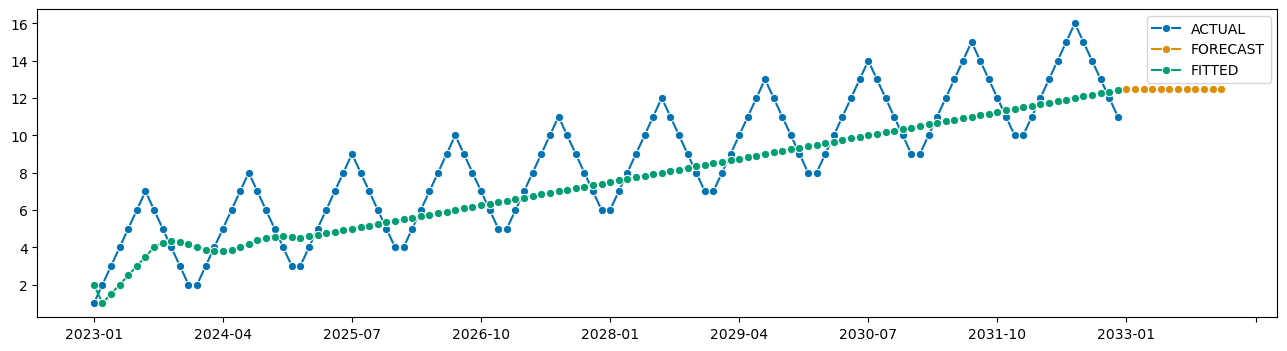

In [160]:
m = NaiveForecaster(strategy="mean", window_length=24)
make_forecast(m, ts)

c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\sktime\forecasting\base\_base.py:1035: UserWarning: empty y passed to update_predict, no update was carried out
  warn("empty y passed to update_predict, no update was carried out")


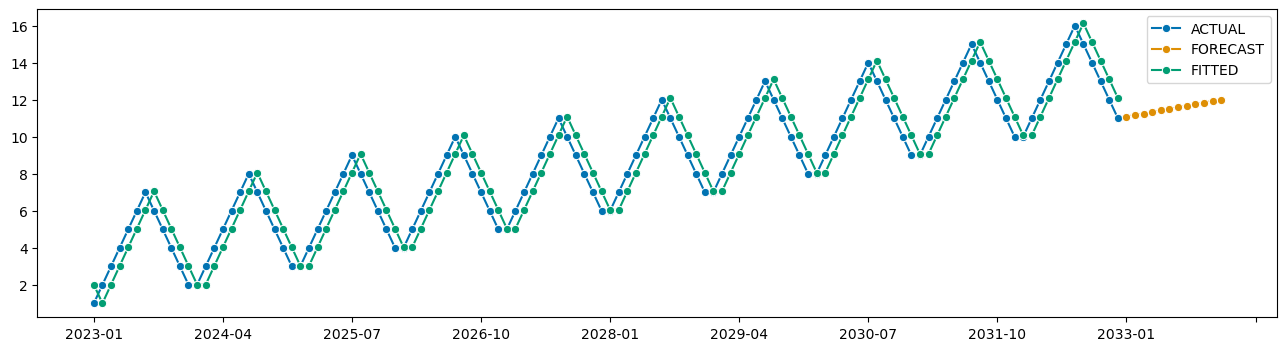

In [161]:
m = NaiveForecaster(strategy="drift")
make_forecast(m, ts)

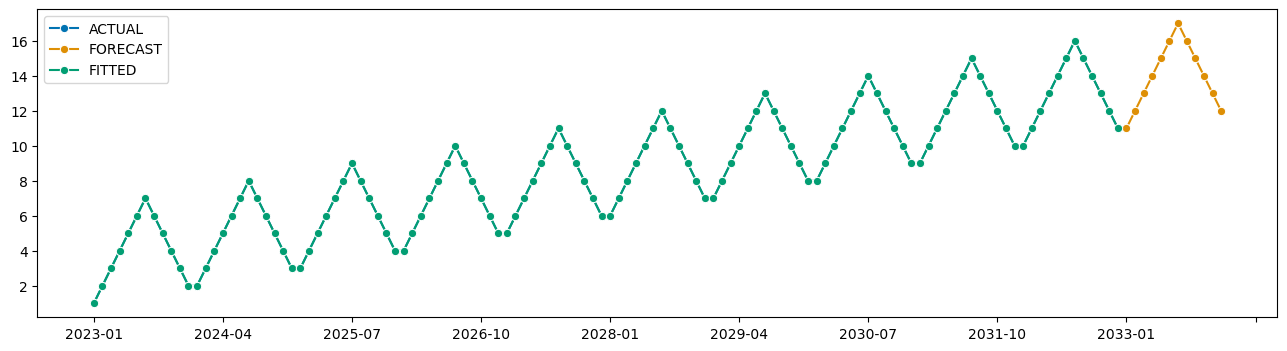

In [162]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting._classes import BaseForecastingErrorMetric, MeanSquaredError
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.compose import make_reduction
from sklearn.linear_model import LinearRegression
from sktime.forecasting.theta import ThetaForecaster

m = ExponentialSmoothing(sp=12, trend="add", seasonal="add")
make_forecast(m, ts)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

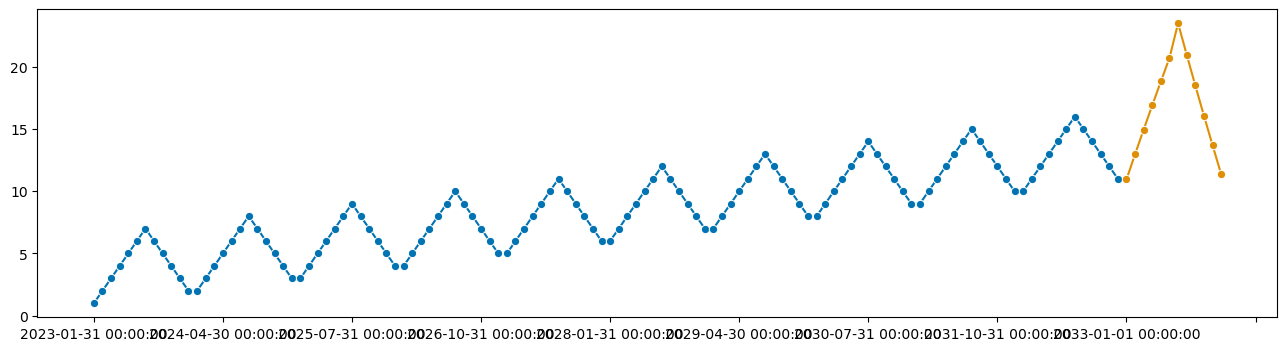

In [163]:
m = ThetaForecaster(sp=12)
m.fit(ts.to_period())
preds = m.predict(fh=np.arange(1, 13))
plot_series(ts, preds.to_timestamp())


ADF Statistic: 2.475729
p-value: 0.999042
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
ADF Statistic: -2450904627297806.500000
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


<AxesSubplot: >

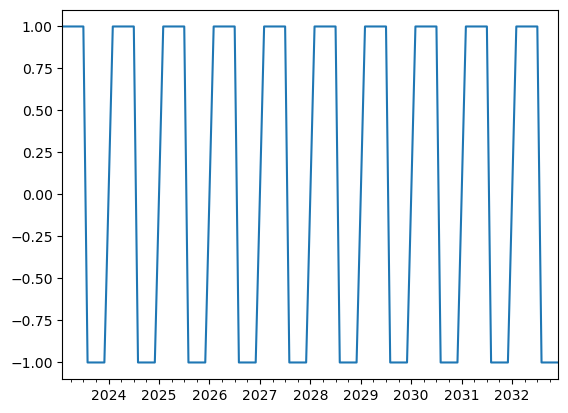

In [164]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(y):
    result = adfuller(y)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

check_stationarity(ts)
check_stationarity(ts.diff().dropna())

ts.diff().dropna().plot()

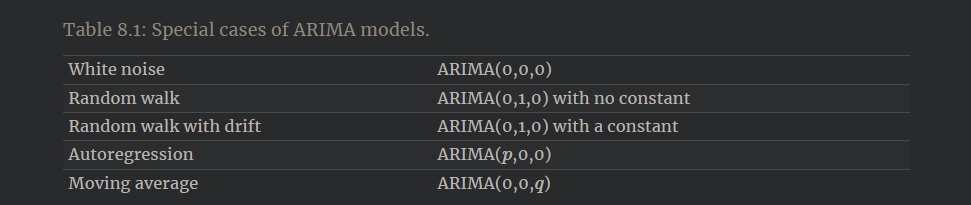

c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2023-01-31     0.999998
2023-02-28     0.999998
2023-03-31     0.999998
2023-04-30     0.999998
2023-05-31     0.999998
                ...    
2032-08-31    14.999998
2032-09-30    13.999998
2032-10-31    12.999998
2032-11-30    11.999998
2032-12-31    10.999998
Length: 120, dtype: float64

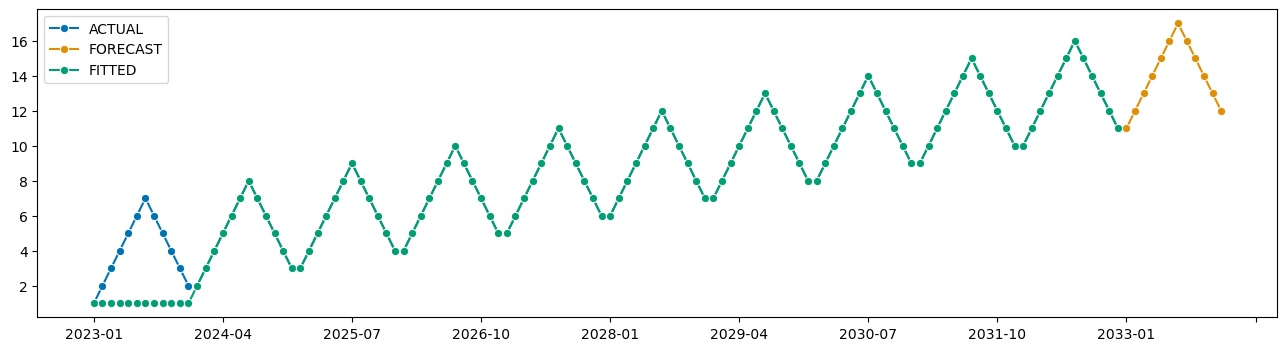

In [165]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(ts.index, is_relative=False)
m = ARIMA((0, 0, 0), seasonal_order=(0, 1, 0, 12))
make_forecast(m, ts)

# print(ts.tail())
m.fit(ts)
m.predict(fh)

c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wojtek\anaconda3\envs\energy\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting 

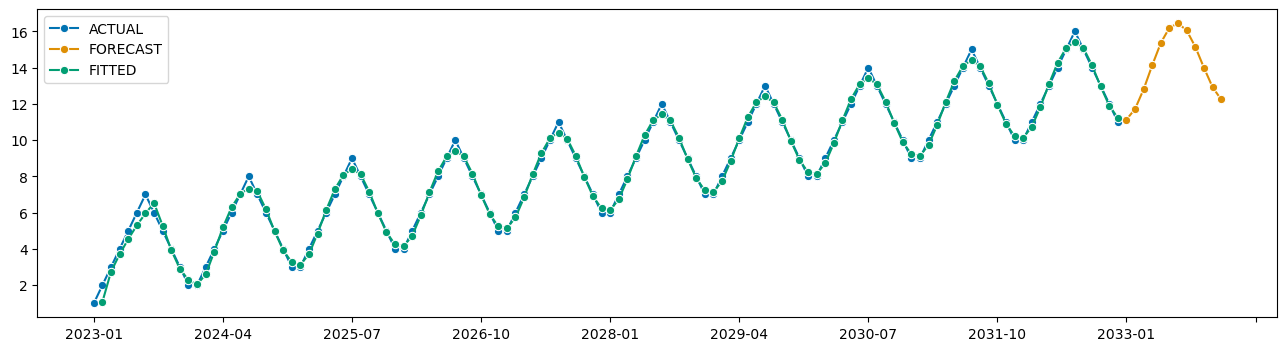

In [166]:
m = AutoARIMA()
make_forecast(m, ts)

In [154]:
m.get_fitted_params()

{'intercept': 0.02202607673555658,
 'ar.L1': 1.7337524870898586,
 'ar.L2': -0.9981421695170641,
 'ma.L1': -2.803929153214277,
 'ma.L2': 2.6253171678391825,
 'ma.L3': -0.8209513106167626,
 'sigma2': 0.05268573776924017,
 'order': (2, 1, 3),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 26.82815845095484,
 'aicc': 27.83716745996385,
 'bic': 46.28202290273555,
 'hqic': 34.72775869161504}

In [167]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

m = RandomForestRegressor()
m = make_reduction(m)
make_forecast(m,ts)

NotImplementedError: Generating in-sample predictions is not yet implemented for RecursiveTabularRegressionForecaster.